In [9]:
import json
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.preprocessing import RobustScaler

import platform
if platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = ['Songti SC']
elif platform.system() == 'Windows':
    plt.rcParams['font.family'] = ['SimSun']
else:  # Linux
    plt.rcParams['font.family'] = ['Noto Sans CJK SC']
matplotlib.rcParams['axes.unicode_minus'] = False # 解决负号显示问题

In [10]:
config = {}
with open('./config.json', 'r', encoding='utf-8') as f:
    config= json.load(f)

print(json.dumps(config, indent=2, ensure_ascii=False))

{
  "scaler_factors": [
    "30min",
    "1hour",
    "4hour",
    "1day"
  ],
  "data_path": "../data/",
  "unit_test": false,
  "props": [
    {
      "model_config": {
        "seq_length": 24,
        "pred_length": 4,
        "gate_hidden_dim": 128,
        "batch_size": 64,
        "learning_rate": 0.001,
        "expert_hidden_dims": {
          "30min": 64,
          "1hour": 64,
          "4hour": 32,
          "1day": 32
        },
        "expert_arch": {
          "high_freq": {
            "conv_channels": [
              30,
              16,
              32
            ],
            "lstm_units": 64,
            "bidirectional": true
          },
          "low_freq": {
            "transformer_layers": 3,
            "nhead": 4,
            "ff_dim": 128
          }
        },
        "gate_network": {
          "hidden_dims": [
            256,
            128
          ],
          "dropout": 0.2
        }
      },
      "trade_config": {
        "batch_size": 128,


In [11]:

class MultiScaleStockDataset(Dataset):
    """
    scaler_factors=['30min', '1hour', '4hour', '1day'],
    """
    def __init__(self, scaler_factors=None, data=None,
                 seq_length=120,
                 pred_steps=1,
                 target_scale='30min',
                 file_path=None, prefix=None):
        super().__init__()
        if scaler_factors is None:
            scaler_factors = ['30min', '1hour', '4hour', '1day']
        self.data = data
        self.seq_length = seq_length
        self.pred_steps= pred_steps
        self.target_scale = target_scale
        self.scaler_factors = scaler_factors
        self.feature_scaler = RobustScaler()
        self.raw_data = {
            scaler: self._import_synthetic_data(file_path=file_path, file_name=f"{prefix}{scaler}") for scaler in scaler_factors
        }
        self.time_serial = self.raw_data[scaler_factors[0]].index
        self.aligned_data = self._align_time_index(data=self.raw_data)
        self._normalize_data()
        self.feature_dims = {
            scale: data.shape[1] for scale, data in self.raw_data.items()
        }
        self.feature_names = self.raw_data[scaler_factors[0]].columns.tolist()

    def split_dataset(self, test_ratio=0.2):
        """时序安全的数据分割"""
        total_len = len(self)
        split_idx = int(total_len * (1 - test_ratio))
        return Subset(self, range(split_idx)), Subset(self, range(split_idx, total_len))

    def _align_time_index(self, base_scale='30min', data=None):
        """以最细粒度时间轴为基准进行对齐"""
        base_df = data[base_scale]
        aligned_data = {}
        daily_df = data['1day'].copy()    
        # 将日级数据时间对齐到基准时间轴的自然日边界
        daily_df.index = daily_df.index.normalize() + pd.Timedelta(hours=23)  # 对齐到23:00  
        for scale, df in data.items():
            if scale == '1day':
                aligned_df = daily_df.reindex(base_df.index, method='ffill')
                # 清除跨日数据
                mask = (aligned_df.index.time == pd.to_datetime('23:00').time()).reshape(-1, 1)
                mask = np.tile(mask, (1, aligned_df.shape[1]))  # 扩展到所有列
                
                # 应用mask并前向填充
                aligned_df = pd.DataFrame(
                    np.where(mask, aligned_df.values, np.nan),
                    index=aligned_df.index,
                    columns=aligned_df.columns
                ).ffill()
            else:    
                # 前向填充粗粒度数据
                aligned_df = df.reindex(base_df.index, method='ffill')
            aligned_data[scale] = aligned_df.dropna()
        # 统一裁剪时保留有效时间边界
        min_len = min(len(df[(df.index >= base_df.index[0]) & 
                            (df.index <= base_df.index[-1])]) 
                    for df in aligned_data.values())
        for scale in aligned_data:
            aligned_data[scale] = aligned_data[scale].iloc[:min_len]

        return aligned_data
    def __getitem__(self, idx):
        """""""""  """
        features = {}
        target_idx = idx + self.seq_length

        # 获取各尺度特征序列
        for scale in self.scaler_factors:
            scale_data = self.aligned_data[scale].iloc[idx:idx + self.seq_length]
            features[scale] = torch.FloatTensor(scale_data.drop(columns=['close']).values)

        # 获取目标值
        target = self.aligned_data[self.target_scale]['close'].iloc[
                 target_idx:target_idx + self.pred_steps
        ]

        return features,  torch.FloatTensor(target.values)

    def __len__(self):
        return len(self.aligned_data[self.target_scale]) - self.seq_length - self.pred_steps

    def _import_synthetic_data(self, file_path=None, file_name=None):
        """生成数据"""
        if file_path is None:
            return self.data
        data = pd.read_csv(f"{file_path}/{file_name}.csv",
                           parse_dates=['date'],
                           index_col='date')

        return data.dropna()

    def _normalize_data(self):
        """分离特征与目标的标准化"""
        self.scalers = {'features': {}, 'target': {}}

        # 特征标准化（排除close）
        for scale in self.scaler_factors:
            feature_cols = [c for c in self.aligned_data[scale].columns if c != 'close']

            self.aligned_data[scale][feature_cols] = self.feature_scaler.fit_transform(
                self.aligned_data[scale][feature_cols]
            )
            self.scalers['features'][scale] = self.feature_scaler

        # 目标值标准化（仅close）
        target_scaler = RobustScaler()
        for scale in self.scaler_factors:
            self.aligned_data[scale]['close'] = target_scaler.fit_transform(
                self.aligned_data[scale][['close']]
            )
        self.scalers['target'] = target_scaler
    def _validate_features(self):
        """日级数据完整性检查"""
        daily_data = self.aligned_data['1day']
        
        # 检查每日数据唯一性
        day_groups = daily_data.groupby(pd.Grouper(freq='D'))
        for date, group in day_groups:
            if len(group) > 0:
                # 验证当日所有记录相同
                if not group.eq(group.iloc[0]).all().all():
                    raise ValueError(f"Daily data inconsistency on {date.strftime('%Y-%m-%d')}")
    
        # 检查时间戳是否在每日23:00
        assert all(ts.time() == pd.to_datetime('23:00').time() 
               for ts in daily_data.resample('D').last().index), \
           "Daily data timestamps misaligned"
        
        """确保所有尺度包含相同特征且排除目标列"""
        base_columns = set(self.aligned_data[self.scaler_factors[0]].columns) - {'close'}
        for scale in self.scaler_factors:
            assert 'close' in self.aligned_data[scale].columns, \
                f"Close price missing in {scale} scale!"
            assert set(self.aligned_data[scale].columns) - {'close'} == base_columns, \
                f"Feature mismatch in {scale} scale!"
    def print(self):
        for scale, data in self.aligned_data.items():
            print(f"{scale}: {data.shape}")
            if(scale == '1day'):
                print(data.head(50))

In [12]:
dataset = MultiScaleStockDataset(file_path=config['data_path'], 
                                 scaler_factors=config['scaler_factors'], 
                                 prefix='train-')
# dataset.print()

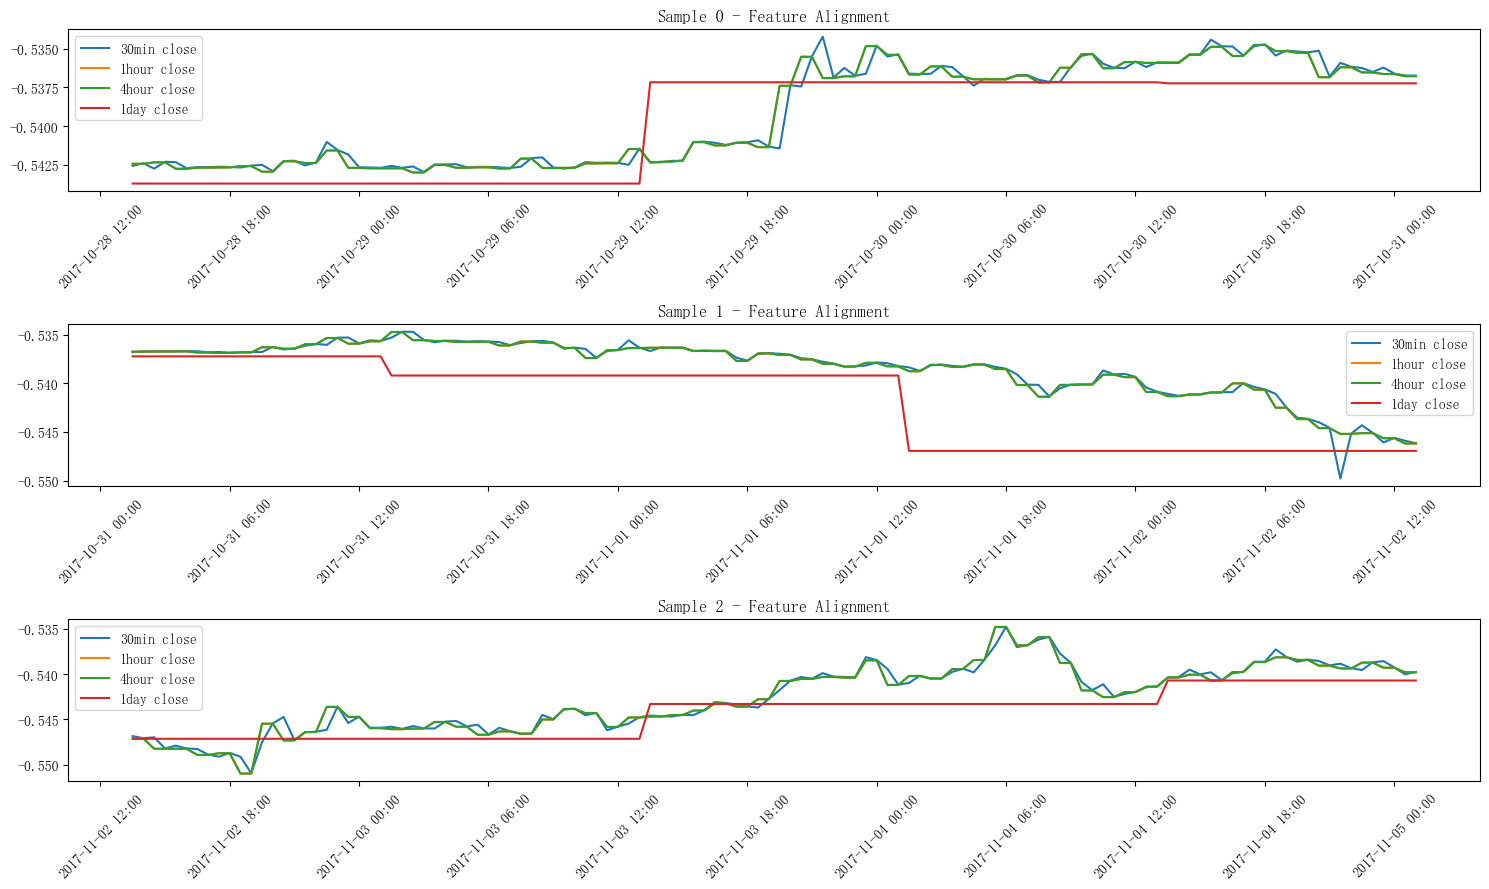

In [13]:
def plot_temporal_alignment(dataset, n_samples=3):
    time_serial = dataset.time_serial
    fig, axs = plt.subplots(n_samples, 1, figsize=(15, 3*n_samples))
    
    for i in range(n_samples):
        idx = i * dataset.seq_length  # Calculate actual data position
        sample_dates = time_serial[idx:idx+dataset.seq_length]
        sample = dataset[i]
        for scale in dataset.scaler_factors:
            features = dataset.aligned_data[scale].iloc[idx:idx+dataset.seq_length, 0]
            axs[i].plot(sample_dates, features, label=f'{scale} close')
        axs[i].set_title(f'Sample {i} - Feature Alignment')
        plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45)
        axs[i].legend()
        axs[i].xaxis.set_major_locator(mdates.AutoDateLocator())
        axs[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
    plt.tight_layout()
    plt.show()
plot_temporal_alignment(dataset)

In [14]:
class ScaleAwareExpert(nn.Module):
    """专家"""
    def __init__(self, input_dim, scale_type):
        super().__init__()
        self.scale_type = scale_type
        if '30min' in scale_type or '1hour' in scale_type:
            """高频专家: CNN + BiLSTM """
            self.proj_in = nn.Linear(input_dim, 30)  # 新增维度对齐层
            self.conv = nn.Conv1d(input_dim, 
                                  out_channels=16,
                                  kernel_size=3, 
                                  padding='same')
            self.lstm = nn.LSTM(16,32, num_layers=2, batch_first=True, bidirectional=True)
            self.proj = nn.Linear(64,32)
        else:
            """低频专家: LSTM """
            self.proj_in = nn.Linear(input_dim, 4)  # 3维→4维
            self.encoder_layer = nn.TransformerEncoderLayer(d_model=4, 
                                                            nhead=2, 
                                                            dim_feedforward=64, 
                                                            batch_first=True)
            self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=3)
            self.proj = nn.Linear(4, 32)
        self.predictor = nn.Linear(32, 1)

    def forward(self, x):
        print(f"Input shape: {x.shape}") 
        """输入: [batch, seq_len, dim]"""
        if '30min' in self.scale_type or '1h' in self.scale_type:
            x = self.proj_in(x)
            x = self.conv(x.permute(0,2,1)).permute(0,2,1)
            x, _ = self.lstm(x)
            x = x[:, -1, :]  # 取最后一个时间步 [batch, 4]
            x = self.proj(x)
        else:
            x = self.proj_in(x)
            x = self.transformer(x)
            x = self.proj(x[:,-1,:]) # 只取最后一个时间步的输出
        return self.predictor(x)

In [15]:
class DymaMoE(nn.Module):
    """动态混合专家网络"""
    def __init__(self, input_dim=30, experts=['30min','1hour','4hour','1day'], hidden_dim=64, output_dim=1):
        super().__init__()
        self.experts = nn.ModuleDict({
            scale: ScaleAwareExpert(input_dim, scale) for scale in experts
        })

        self.gate = nn.Sequential(
            nn.Linear(input_dim * len(experts), hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, len(experts)),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, inputs):
        expert_outputs = {}
        for scale, expert in self.experts.items():
            # expert_outputs[scale] = expert(inputs[scale])
            expert_outputs[scale] = expert(inputs[scale]).squeeze(-1)  # [32,1] -> [32]
        # 动态门控
        gate_input = torch.cat([v for v in inputs.values()], dim=-1)
    
        weights = self.gate(gate_input.mean(dim=1))  # (batch, num_experts)
        
        # 加权融合
        combined = sum(weights[:, i] * expert_outputs[scale] 
                      for i, scale in enumerate(self.experts.keys()))
        return combined.unsqueeze(-1), expert_outputs  


In [ ]:
def train(dataset, model_config =None, trade_config = None):
    """train dataset"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DymaMoE(input_dim=30).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=model_config['learning_rate'])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    def hybrid_loss(pred, target, expert_outs, alpha=0.7):
        pred = pred.squeeze(-1)  # (32,1) → (32)
        target = target.squeeze()  # [32] remains
        mse = nn.MSELoss()
        main_loss = mse(pred, target)
        
        # 趋势一致性约束
        expert_tensor = torch.stack(list(expert_outs.values()))  # [num_experts, batch]
        # trends = torch.sign(expert_tensor.detach())  # [num_experts, batch]
        trends = torch.stack([
            torch.sign(expert_outs['30min'].detach()),
            torch.sign(expert_outs['1hour'].detach()), 
            torch.sign(expert_outs['4hour'].detach()),
            torch.sign(expert_outs['1day'].detach())
        ])
        # trends = torch.stack([torch.sign(out.detach()) for out in expert_outs.values()])
        consistency = torch.mean(torch.prod(trends, dim=0))
        
        return alpha*main_loss + (1-alpha)*(1 - consistency)
    loss_history = []
    expert_weights = []
    predictions = []
    targets = []
    loader = DataLoader(dataset, batch_size=trade_config['batch_size'], shuffle=True)
    for epoch in range(trade_config['epochs']):
        epoch_loss = 0
        model.train()
        for batch_idx, (inputs, target) in enumerate(loader):
           # 修复输入格式问题
            if isinstance(inputs, dict):  # 保持原有字典处理
                inputs = {k:v.to(device) for k,v in inputs.items()}
            else:  # 处理张量输入的情况
                print(inputs)
                inputs = inputs.to(device)
            
            target = target.to(device)
            
            pred, expert_outs = model(inputs)
            loss = hybrid_loss(pred, target, expert_outs)
            
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            # 收集预测结果
            with torch.no_grad():
                preds = pred.squeeze().cpu().numpy()
                predictions.extend(preds)
                targets.extend(target.cpu().numpy())
            
            epoch_loss += loss.item()
        # 记录专家权重
        with torch.no_grad():
            dummy_input = {k: torch.randn(1,24,30).to(device) for k in model.experts}
            _, weights = model(dummy_input)
            expert_weights.append([list(out.parameters())[0].detach().cpu().numpy().mean() for out in model.experts.values()])
            # expert_weights.append(weights.cpu().numpy()[0])
            # expert_weights.append([
            #     list(model.experts['30min'].parameters())[0].detach().cpu().numpy().mean(),
            #     list(model.experts['1hour'].parameters())[0].detach().cpu().numpy().mean(),
            #     list(model.experts['4hour'].parameters())[0].detach().cpu().numpy().mean(),
            #     list(model.experts['1day'].parameters())[0].detach().cpu().numpy().mean()
            # ])
        
        avg_loss = epoch_loss / len(loader)
        loss_history.append(avg_loss)    
        scheduler.step()
        print(f'Epoch {epoch} Loss: {loss.item():.4f}')
    return model, (loss_history, expert_weights), (targets, predictions)

model, history, results = train(dataset=dataset, 
                                model_config=config['props'][0]['model_config'], 
                                trade_config = config['props'][0]['trade_config'])

Input shape: torch.Size([128, 120, 30])
Input shape: torch.Size([128, 120, 30])
Input shape: torch.Size([128, 120, 30])
Input shape: torch.Size([128, 120, 30])
Input shape: torch.Size([128, 120, 30])
Input shape: torch.Size([128, 120, 30])
Input shape: torch.Size([128, 120, 30])
Input shape: torch.Size([128, 120, 30])
Input shape: torch.Size([128, 120, 30])
Input shape: torch.Size([128, 120, 30])
Input shape: torch.Size([128, 120, 30])
Input shape: torch.Size([128, 120, 30])
Input shape: torch.Size([128, 120, 30])
Input shape: torch.Size([128, 120, 30])
Input shape: torch.Size([128, 120, 30])
Input shape: torch.Size([128, 120, 30])
Input shape: torch.Size([128, 120, 30])
Input shape: torch.Size([128, 120, 30])
Input shape: torch.Size([128, 120, 30])
Input shape: torch.Size([128, 120, 30])
Input shape: torch.Size([128, 120, 30])
Input shape: torch.Size([128, 120, 30])
Input shape: torch.Size([128, 120, 30])
Input shape: torch.Size([128, 120, 30])
Input shape: torch.Size([128, 120, 30])


In [ ]:
def visualize_training(loss_history, expert_weights, targets, predictions):
    """训练过程可视化分析"""
    plt.figure(figsize=(15,5))
    
    # 损失曲线
    plt.subplot(1,3,1)
    plt.plot(loss_history, label='Training Loss')
    plt.title("Loss Curve")
    plt.xlabel("Epoch"), plt.ylabel("Loss")
    
    # 专家权重分布
    plt.subplot(1,3,2)
    sns.heatmap(np.array(expert_weights), cmap='viridis', 
                xticklabels=['30min','1h','4h','1d'])
    plt.title("Expert Weights Distribution")
    plt.xlabel("Experts"), plt.ylabel("Epoch")
    
    # 预测结果示例
    plt.subplot(1,3,3)
    plt.scatter(targets[:100], predictions[:100], alpha=0.5)
    plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--')
    plt.title("Predictions vs Ground Truth")
    plt.xlabel("True Values"), plt.ylabel("Predictions")
    
    plt.tight_layout()
    plt.show()

"""可视化分析"""
visualize_training(history[0], history[1], targets=results[0], predictions=results[1])